## Imports

In [1]:
import numpy as np
import pandas as pd

from baybe.targets import NumericalTarget
from baybe.objective import Objective

from baybe.parameters import NumericalDiscreteParameter
from baybe.searchspace import SearchSpace

from baybe.recommenders import RandomRecommender, SequentialGreedyRecommender, NaiveHybridRecommender
from baybe.surrogates import GaussianProcessSurrogate

from baybe.strategies import TwoPhaseStrategy
from baybe import Campaign

### Setting the objectives

The DESIRABILITY mode enables the combination multiple targets via scalarization into a single value.

Connection to the Pareto front? - Alternative way to do it, fully multi-objective optimization is in the works.

Check MATCH mode, instead of MAX/MIN + For more details on transformation functions: 
https://emdgroup.github.io/baybe/userguide/targets.html

In [2]:
overpotential = NumericalTarget(
    name="overpotential", 
    mode="MAX", 
    bounds=(-400, 0),
    transformation="LINEAR"  # optional, will be applied if bounds are not None, LINEAR only one available for MAX/MIN
    ) 

overpotential_slope = NumericalTarget(
    name="overpotential_slope", 
    mode="MAX", 
    bounds=(-0.05, 0.05),
    transformation="LINEAR"  # optional, will be applied if bounds are not None, LINEAR only one available for MAX/MIN
    )

objective = Objective(
    mode="DESIRABILITY",
    targets=[overpotential, overpotential_slope],
    weights=[1.0, 1.0],  # optional, by default all weights are equal
    combine_func="GEOM_MEAN",  # optional, geometric mean is the default
)

### Search Space

In [3]:
parameters = [
NumericalDiscreteParameter(
    name="Tungstate_concentration[M]",
    values=np.arange(0.05, 0.21, 0.01),
    tolerance = 0.004,  # allows experimental inaccuracies up to 0.004 when reading values
    # ValueError: Parameter 'Tungstate_concentration[M]' is initialized with tolerance 0.005 but
    # due to the given parameter values, the specified tolerance must be smaller than 0.004999999999999977 to avoid ambiguity.
),
NumericalDiscreteParameter(
    name="Current_density[mA/cm2]",
    values=np.arange(5, 130, 5),
    tolerance = 2,  # allows experimental inaccuracies up to 2 when reading values, same as above
),
NumericalDiscreteParameter(
    name="Deposition_time[s]",
    values=np.arange(60, 610, 10),
    tolerance = 4.9,  # allows experimental inaccuracies up to 4.9 when reading values
),
NumericalDiscreteParameter(
        name="pH",
        values=np.arange(5, 10.5, 0.5),
        tolerance=0.2,  # allows experimental inaccuracies up to 0.49 when reading values
    )
]

searchspace = SearchSpace.from_product(parameters)

### Recommenders

The **SequentialGreedyRecommender** is a powerful recommender that leverages BoTorch optimization functions to perform sequential Greedy optimization. It can be applied for discrete, continuous and hybrid sarch spaces. It is an implementation of the BoTorch optimization functions for discrete, continuous and mixed spaces. **It is important to note that this recommender performs a brute-force search when applied in hybrid search spaces, as it optimizes the continuous part of the space while exhaustively searching choices in the discrete subspace.** You can customize this behavior to only sample a certain percentage of the discrete subspace via the sample_percentage attribute and to choose different sampling strategies via the hybrid_sampler attribute. 

e.g.
strategy = TwoPhaseStrategy(recommender=SequentialGreedyRecommender(hybrid_sampler="Farthest", sampling_percentage=0.3))

The **NaiveHybridRecommender** can be applied to all search spaces, but is intended to be used in hybrid spaces. This recommender **combines individual recommenders for the continuous and the discrete subspaces. It independently optimizes each subspace and consolidates the best results to generate a candidate for the original hybrid space.** 

For implementing fully customized surrogate models e.g. from sklearn or PyTorch, see:
https://emdgroup.github.io/baybe/examples/Custom_Surrogates/Custom_Surrogates.html


In [4]:
available_surr_models = [
    "GaussianProcessSurrogate", 
    "BayesianLinearSurrogate",
    "MeanPredictionSurrogate",
    "NGBoostSurrogate",
    "RandomForestSurrogate"
]

available_acq_functions = [
    "qPI",  # q-Probability Of Improvement
    "qEI",  # q-Expected Improvement
    "qUCB", # q-upper confidence bound with beta of 1.0
]

# Defaults anyway
SURROGATE_MODEL = GaussianProcessSurrogate()
ACQ_FUNCTION = "qEI" # q-Expected Improvement, only q-fuctions are available for batch_size > 1

seq_greedy_recommender = SequentialGreedyRecommender(
        surrogate_model=SURROGATE_MODEL,
        acquisition_function_cls=ACQ_FUNCTION,
        hybrid_sampler="Farthest", # find more details in the documentation
        sampling_percentage=0.3, # should be relatively low
        allow_repeated_recommendations=False,
        allow_recommending_already_measured=False,
    )

hybrid_recommender = NaiveHybridRecommender(
    allow_repeated_recommendations=False,
    allow_recommending_already_measured=False
)

c:\Users\lordm\Desktop\Projects\baybe\.venv\lib\site-packages\baybe\recommenders\bayesian.py:492: UserWarning: The value of 'allow_recommending_already_measured' differs from what is specified in the discrete recommender. The value of the discrete recommender will be ignored.
  warnings.warn(


### Campaign Strategy

In [5]:
strategy = TwoPhaseStrategy(
    initial_recommender = RandomRecommender(),  # Initial recommender, if no training data is available
    # Other initial recommenders don't seem to work for my hybrid search space/set of parameters
    # Doesn't matter since I already have training data
    recommender = seq_greedy_recommender,  # Bayesian model-based optimization
    # recommender = hybrid_recommender,
    switch_after=1  # Switch to the model-based recommender after 1 batch or iteration (so the initial training data)
)

campaign = Campaign(searchspace, objective, strategy)

In [6]:
unique_parameters = ["Tungstate_concentration[M]", "Current_density[mA/cm2]", "Deposition_time[s]", "pH"] 
unique_objectives = ["overpotential", "overpotential_slope"]

# EXAMPLE, here use actual data
X_train = np.array([[0.05, 10, 500, 5],
               [0.05, 50, 300, 6],
               [0.1, 10, 300, 7],
               [0.1, 10, 600, 8],
               
               [0.1, 50, 600, 7.5],
               [0.1, 100, 600, 10],
               [0.1, 50, 400, 6.5],
               [0.1, 30, 600, 8.5],
               [0.15, 10, 600, 9.5],
               [0.15, 50, 300, 9.5]])

# Convert to dataframe
X_train = pd.DataFrame(X_train, columns=unique_parameters)

# EXAMPLE, here use actual observations
y_train = np.array([[-358,0.00015], 
                    [-319,0.000066], 
                    [-377,0.0001], 
                    [-319,-0.000518],
                    [-286,0.00008], 
                    [-312,0.000029], 
                    [-309,-0.000057], 
                    [-290,0.001656],
                    [-329,0.000131], 
                    [-305,-0.000064]])

# Convert to dataframe
y_train = pd.DataFrame(y_train, columns=unique_objectives)

rec_init = pd.concat([X_train, y_train], axis=1)

# Add initial data to the campaign
campaign.add_measurements(rec_init)
print("\n\nInitial experiments with measured values: ")
print(rec_init.to_markdown())



Initial experiments with measured values: 
|    |   Tungstate_concentration[M] |   Current_density[mA/cm2] |   Deposition_time[s] |   pH |   overpotential |   overpotential_slope |
|---:|-----------------------------:|--------------------------:|---------------------:|-----:|----------------:|----------------------:|
|  0 |                         0.05 |                        10 |                  500 |  5   |            -358 |              0.00015  |
|  1 |                         0.05 |                        50 |                  300 |  6   |            -319 |              6.6e-05  |
|  2 |                         0.1  |                        10 |                  300 |  7   |            -377 |              0.0001   |
|  3 |                         0.1  |                        10 |                  600 |  8   |            -319 |             -0.000518 |
|  4 |                         0.1  |                        50 |                  600 |  7.5 |            -286 |              

Available measurements can be submitted at any time and also several times before querying the next recommendations.

### Batch Optimization

If you have a fixed experimental budget but the luxury of choosing whether to run your experiments sequentially or in parallel, sequential experimentation will give you the better overall results in expectation. This is because in the sequential approach, each subsequent recommendation can leverage the additional data from previous iterations, which allows more accurate predictive models to be built. However, in real-world use cases, the question is typically answered by other factors, such as whether parallel experimentation is feasible in the first place, or whether the given time budget even allows for sequential runs.

In [7]:
rec = campaign.recommend(batch_size=3)
print("\n\nRecommended experiments: ")
print(rec.to_markdown())

c:\Users\lordm\Desktop\Projects\baybe\.venv\lib\site-packages\baybe\campaign.py:275: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self._measurements_exp["FitNr"].fillna(self.n_fits_done, inplace=True)
c:\Users\lordm\Desktop\Projects\baybe\.venv\lib\site-packages\botorch\acquisition\monte_carlo.py:399: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po



Recommended experiments: 
|   index |   Tungstate_concentration[M] |   Current_density[mA/cm2] |   Deposition_time[s] |   pH |
|--------:|-----------------------------:|--------------------------:|---------------------:|-----:|
|   20565 |                         0.06 |                        45 |                  600 |  8   |
|   97918 |                         0.11 |                        60 |                  520 |  8.5 |
|  127647 |                         0.13 |                        55 |                  600 |  6.5 |


In [8]:
rec["overpotential"] = [-344, -322, -389]
rec["overpotential_slope"] = [-0.02, -0.03, -0.04]
campaign.add_measurements(rec)
print("\n\nRecommended experiments with measured values: ")
print(rec.to_markdown())



Recommended experiments with measured values: 
|   index |   Tungstate_concentration[M] |   Current_density[mA/cm2] |   Deposition_time[s] |   pH |   overpotential |   overpotential_slope |
|--------:|-----------------------------:|--------------------------:|---------------------:|-----:|----------------:|----------------------:|
|   20565 |                         0.06 |                        45 |                  600 |  8   |            -344 |                 -0.02 |
|   97918 |                         0.11 |                        60 |                  520 |  8.5 |            -322 |                 -0.03 |
|  127647 |                         0.13 |                        55 |                  600 |  6.5 |            -389 |                 -0.04 |


In [9]:
new_rec = campaign.recommend(batch_size=3)
print("\n\nRecommended experiments: ")
print(new_rec.to_markdown())

c:\Users\lordm\Desktop\Projects\baybe\.venv\lib\site-packages\baybe\campaign.py:275: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self._measurements_exp["FitNr"].fillna(self.n_fits_done, inplace=True)
c:\Users\lordm\Desktop\Projects\baybe\.venv\lib\site-packages\botorch\acquisition\monte_carlo.py:399: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po



Recommended experiments: 
|   index |   Tungstate_concentration[M] |   Current_density[mA/cm2] |   Deposition_time[s] |   pH |
|--------:|-----------------------------:|--------------------------:|---------------------:|-----:|
|   54760 |                         0.08 |                        80 |                  340 |    6 |
|  144726 |                         0.14 |                        75 |                  170 |   10 |
|  199352 |                         0.18 |                        25 |                  330 |   10 |


In [10]:
new_rec["overpotential"] = [-250, -278, -298]
new_rec["overpotential_slope"] = [-0.025, -0.0001, -0.06]
print("\n\nRecommended experiments with measured values: ")
print(new_rec.to_markdown())



Recommended experiments with measured values: 
|   index |   Tungstate_concentration[M] |   Current_density[mA/cm2] |   Deposition_time[s] |   pH |   overpotential |   overpotential_slope |
|--------:|-----------------------------:|--------------------------:|---------------------:|-----:|----------------:|----------------------:|
|   54760 |                         0.08 |                        80 |                  340 |    6 |            -250 |               -0.025  |
|  144726 |                         0.14 |                        75 |                  170 |   10 |            -278 |               -0.0001 |
|  199352 |                         0.18 |                        25 |                  330 |   10 |            -298 |               -0.06   |


Merge full results into dataframe:

In [11]:
results = pd.concat([rec_init, rec, new_rec])
print("\n\nAll experiments with measured values: ")
print(results.to_markdown())



All experiments with measured values: 
|        |   Tungstate_concentration[M] |   Current_density[mA/cm2] |   Deposition_time[s] |   pH |   overpotential |   overpotential_slope |
|-------:|-----------------------------:|--------------------------:|---------------------:|-----:|----------------:|----------------------:|
|      0 |                         0.05 |                        10 |                  500 |  5   |            -358 |              0.00015  |
|      1 |                         0.05 |                        50 |                  300 |  6   |            -319 |              6.6e-05  |
|      2 |                         0.1  |                        10 |                  300 |  7   |            -377 |              0.0001   |
|      3 |                         0.1  |                        10 |                  600 |  8   |            -319 |             -0.000518 |
|      4 |                         0.1  |                        50 |                  600 |  7.5 |        

In [ ]:
# Could also add fake results with:
# from baybe.utils.dataframe import add_fake_results
# add_fake_results(rec, campaign)
# print("\n\nRecommended experiments with fake measured values: ")
# print(rec.to_markdown())

# BUT the values provided won't make sense for the given parameters, so I'll just use my 'fake' actual values.

#### Saving & Loading / (De)Serialization

Note that DataFrame objects associated with the Campaign object are converted to a binary format during serialization, which has the consequence that their JSON representation is not human-readable. For more details on config files and their validation: https://emdgroup.github.io/baybe/examples/Serialization/Serialization.html

In [12]:
campaign_json = campaign.to_json()
recreated_campaign = Campaign.from_json(campaign_json)
# assert campaign == recreated_campaign

### Simulation loops/Backtesting

For more info on running **simulations**, i.e. getting different initial 'lookup' sample data from 'Excel' table-based files, comparing recommenders, and plotting the results:
https://emdgroup.github.io/baybe/examples/Backtesting/Backtesting.html

Also includes fully custom BoTorch functions.

### Plotting the data so far

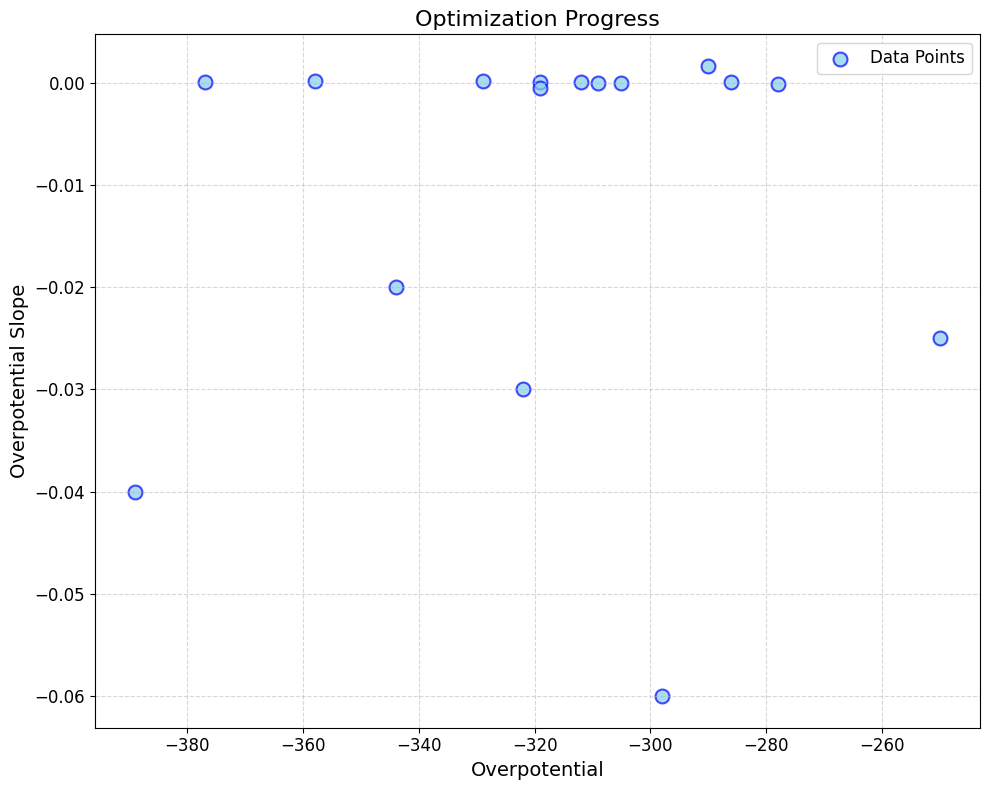

In [13]:
import matplotlib.pyplot as plt

# Extract objective values
objective1 = results['overpotential']
objective2 = results['overpotential_slope']

# Plot objectives against each other
plt.figure(figsize=(10, 8))
plt.scatter(objective1, objective2, c='skyblue', alpha=0.7, edgecolors='b', linewidths=1.5, label='Data Points', marker='o', s=100)

# Add labels and legend
plt.xlabel('Overpotential', fontsize=14)
plt.ylabel('Overpotential Slope', fontsize=14)
plt.title('Optimization Progress', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()